In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import nltk
import re

from nltk.stem import SnowballStemmer
from itertools import combinations
from nltk.corpus import stopwords
from collections import Counter
from unidecode import unidecode
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
pd.set_option('max_colwidth', 200)

In [3]:
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camilo.martinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
rcn_news = pd.read_csv('RCN_news.csv')
print(rcn_news.shape)
rcn_news.head(3)

(9030, 5)


,text,label,url,title,source
0,Fútbol ¡Sonríe el fútbol! Médicos confirman que la salud de Pelé está mejorando Médicos que atienden al exjugador brasileño en Sao Paulo afirman que su condición de salud está mejorando.,deportes,https://www.noticiasrcn.com/deportes/salud-de-pele-esta-mejorando-435134,Salud de pele esta mejorando 435134,rcn
1,"Especial: videojuegos en Colombia El celular, la consola de la pandemia Ante las limitaciones de las cuarentenas, los usuarios encontraron en los videojuegos una nueva forma de entretenimiento a t...",tecnologia,https://www.noticiasrcn.com/tecnologia/el-celular-la-consola-de-la-pandemia-423916,El celular la consola de la pandemia 423916,rcn
2,"TodoGamers FIFA 22 vs eFootball: comparativa gráfica y animaciones Ambos juegos de fútbol llegaron recientemente, aunque las diferencias saltan a la vista.",tecnologia,https://www.noticiasrcn.com/tecnologia/fifa-22-vs-efootball-comparativa-grafica-y-animaciones-389528,Fifa 22 vs efootball comparativa grafica y animaciones 389528,rcn


## Información General

#### Tipos de datos

In [5]:
rcn_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9030 entries, 0 to 9029
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9030 non-null   object
 1   label   9030 non-null   object
 2   url     9030 non-null   object
 3   title   9030 non-null   object
 4   source  9030 non-null   object
dtypes: object(5)
memory usage: 352.9+ KB


#### Valores únicos

In [6]:
for column in rcn_news.columns:
    print(column)
    display(pd.DataFrame(rcn_news[column].value_counts()))

text


,count
text,
Por NoticiasRCN.com hace 2 años Por NoticiasRCN.com hace 2 años,3
"Tecnología Entrevista: Xiaomi y su plan para ""reducir la brecha digital"" en Colombia La empresa china destacó que en países como el nuestro es importante dar acceso a la tecnología con precios competitivos.",2
"Cartagena Ciudadanos extranjeros habrían abusado sexualmente de tres niñas en Cartagena Según información, los presuntos abusadores serían dos hombres venezolanos y un hombre italiano.",1
"Soat Vuelve y juega: Continúan los líos por el trámite del Soat en el país Los motociclistas están convocando manifestaciones para el próximo 23 de noviembre en Bogotá, Cali y Medellín.",1
Primera línea ¿Volverán a la cárcel?: Iván Cepeda responde sobre líderes de la primera línea que serán gestores de paz NoticiasRCN.com habló con el senador Iván Cepeda sobre cuál sería el papel de los gestores de paz de la primera línea.,1
...,...
"Gobierno ""Ya no más bienestarina"": Petro propone compra de cosechas para combatir el hambre El Presidente volvió a hacer serios cuestionamientos por los programas alimentarios del ICBF. Aseguró que se deben entregar alimentos locales.",1
"Maltrato infantil Casos de violencia, abuso y homicidio de niños que estremecen y encienden las alarmas en el país El maltrato infantil no distingue nacionalidad. En las últimas semanas se han presentado casos que encienden las alarmas en el país. Por Yhonay Díaz hace 2 meses Por Yhonay Díaz hace 2 meses",1
Coronavirus en Colombia Uso del tapabocas seguirá siendo obligatorio en Colombia por lo que resta del año: Minsalud El Ministerio de Salud aseguró que portar el tapabocas seguirá siendo obligatorio así se haya alcanzado resultados importantes con la vacunación.,1


label


,count
label,
deportes,1806
tecnologia,1806
colombia,1806
salud,1806
economia,1806


url


,count
url,
https://www.noticiasrcn.com/deportes/salud-de-pele-esta-mejorando-435134,1
https://www.noticiasrcn.com/deportes/catar-2022-seleccion-argentina-llego-a-catar-433888,1
https://www.noticiasrcn.com/tecnologia/videojuegos-que-se-lanzan-en-febrero-para-playstation-xbox-y-nintendo-403914,1
https://www.noticiasrcn.com/colombia/motociclistas-convocan-nueva-jornada-de-movilizaciones-434209,1
https://www.noticiasrcn.com/colombia/ivan-cepeda-sobre-gestores-de-paz-de-la-primera-linea-435346,1
...,...
https://www.noticiasrcn.com/colombia/ninos-victimas-de-maltrato-abuso-y-muerte-en-el-pais-433967,1
https://www.noticiasrcn.com/salud/uso-del-tapabocas-seguira-siendo-obligatorio-en-colombia-durante-2021-390939,1
https://www.noticiasrcn.com/economia/asi-influyen-los-costos-de-produccion-en-la-inflacion-437359,1


title


,count
title,
Salud de pele esta mejorando 435134,1
Catar 2022 seleccion argentina llego a catar 433888,1
Videojuegos que se lanzan en febrero para playstation xbox y nintendo 403914,1
Motociclistas convocan nueva jornada de movilizaciones 434209,1
Ivan cepeda sobre gestores de paz de la primera linea 435346,1
...,...
Ninos victimas de maltrato abuso y muerte en el pais 433967,1
Uso del tapabocas seguira siendo obligatorio en colombia durante 2021 390939,1
Asi influyen los costos de produccion en la inflacion 437359,1


source


,count
source,
rcn,9030


#### Revisar valores numericos estraños en los titulos

In [7]:
cond_number_in_title = rcn_news['title'].str.split().apply(lambda x:  x[-1].isnumeric())

In [8]:
rcn_news['title'].str.split().apply(lambda x: len(x[-1])).value_counts()

title
6     9018
8        4
2        3
5        2
9        1
7        1
10       1
Name: count, dtype: int64

In [9]:
cond_number_in_title.value_counts()

title
True     9018
False      12
Name: count, dtype: int64

In [10]:
rcn_news.loc[cond_number_in_title, 'title'] = \
    rcn_news.loc[cond_number_in_title, 'title'].apply(lambda x: ' '.join(x.split()[:-1]))

#### Remover articulos sin titulo

In [11]:
rcn_news[rcn_news['title'].str.strip() == ""]

,text,label,url,title,source
766,"Esta nueva apuesta, ayuda a que los raperos creen música y rimas, por medio de sugerencias de palabras y melodías con ayuda de la IA. Por NoticiasRCN.com hace 2 años Por NoticiasRCN.com hace 2 años",tecnologia,https://www.noticiasrcn.com/tecnologia/376421,,rcn
1442,Un especialista de Asus te da algunas recomendaciones para mejorar la conectividad de WiFi de tu portatil. ¡Consejos muy útiles! Por NoticiasRCN.com hace 2 años Por NoticiasRCN.com hace 2 años,tecnologia,https://www.noticiasrcn.com/tecnologia/376138,,rcn
2935,"La medida entrará en vigor el próximo 1 de mayo, donde las apps censuradas recibirán una notificación y una sugerencia sobre la información personal. Por NoticiasRCN.com hace 2 años Por NoticiasRC...",tecnologia,https://www.noticiasrcn.com/tecnologia/377428,,rcn
3954,"Spotify, por medio del programa Work From Anywhere quiere que sus empleados se sientan más cómodos trabajando desde cualquier lugar del mundo. Por NoticiasRCN.com hace 2 años Por NoticiasRCN.com h...",tecnologia,https://www.noticiasrcn.com/tecnologia/375683,,rcn
7827,Instituciones financieras de Colombia reportaron un aumento considerable en los ataques cibernéticos durante el 2020. Por NoticiasRCN.com hace 2 años Por NoticiasRCN.com hace 2 años,tecnologia,https://www.noticiasrcn.com/tecnologia/375823,,rcn
7886,"Telegram habilitó la exportación de datos, conversaciones y contactos de WhatsApp, sin embargo, expone la seguridad de los datos de los usuarios, ¿por qué? Por NoticiasRCN.com hace 2 años Por Noti...",tecnologia,https://www.noticiasrcn.com/tecnologia/375001,,rcn
8138,Siga EN VIVO el partido final por el título del Mundial de India 2022 entre Colombia y España. Por NoticiasRCN.com hace 2 meses Por NoticiasRCN.com hace 2 meses,deportes,https://www.noticiasrcn.com/deportes/432694,,rcn
9025,"La función puede hacer que la persona que esté en la foto sonría, parpadee o mueva la cabeza. ¡Muchos están evocando a sus seres queridos muertos! Por NoticiasRCN.com hace 2 años Por NoticiasRCN.c...",tecnologia,https://www.noticiasrcn.com/tecnologia/376336,,rcn


In [12]:
rcn_news = rcn_news[rcn_news['title'].str.strip() != ""].copy().reset_index(drop=True)

In [22]:
rcn_news[['title']].to_csv(
    "/Users/camilo.martinez/Documents/personal-documents/codes/clases-matematicas-mlops/mlops-bootcamp/linear_algebra/data/rcn_news_2022.csv", index=False)

#### Valores faltantes

In [13]:
rcn_news.isnull().sum()

text      0
label     0
url       0
title     0
source    0
dtype: int64

### Preprocesamiento de datos

In [14]:
def clean_text(text):

    # Convierte a minúsculas
    text = text.lower()

    # Elimina tildes, exceptuando la ñ
    text = " ".join(
        [unidecode(word) if 'ñ' not in word else word
        for word in text.split()])

    # Elimina signos de puntacion y caracteres especiales
    text = re.sub(r'[^a-z0-9\sñ]', '', text, re.I | re.A)

    # Elimina espacios dobles
    text = re.sub(r'\s+', ' ', text).strip()

    # Elimina stopwords
    text = ' '.join(
        [word for word in text.split() if word not in spanish_stopwords])

    return text

# Aplicar la limpieza
rcn_news['text_clean'] = rcn_news['text'].apply(clean_text)
rcn_news['title_clean'] = rcn_news['title'].apply(clean_text)

# Stemming
rcn_news['text_steaming'] = rcn_news['text_clean'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

rcn_news['word_count'] = rcn_news['text_clean'].apply(lambda x: len(x.split()))
rcn_news['text_length'] = rcn_news['text_clean'].apply(len)

In [15]:
rcn_news['text_clean']

0                                                 futbol sonrie futbol medicos confirman salud pele mejorando medicos atienden exjugador brasileño sao paulo afirman condicion salud mejorando
1                                    especial videojuegos colombia celular consola pandemia limitaciones cuarentenas usuarios encontraron videojuegos nueva forma entretenimiento traves movil
2                                                   todogamers fifa 22 vs efootball comparativa grafica animaciones ambos juegos futbol llegaron recientemente aunque diferencias saltan vista
3       unidad nacional proteccion director unp denuncio presunto caso corrupcion dentro entidad segun augusto rodriguez vehiculos cuentan condiciones necesarias proteger personas alto nivel
4             coronavirus mundo mas 300 millones casos coronavirus superados mundo segun calculo menos 300042439 casos infeccion sido diagnosticados oficina oms registro aparicion enfermedad
                                             

In [242]:
rcn_news['title_clean']

0                                       salud pele mejorando
1                                   celular consola pandemia
2       fifa 22 vs efootball comparativa grafica animaciones
3                        presunto caso corrupcion dentro unp
4         mas 300 millones casos coronavirus superados mundo
                                ...                         
9017                    truco ios 16 dara mejor calidad vida
9018              vacunas covid 19 protegen variante omicron
9019          wall street inicia semana crucial orden dispar
9020                               voto obligatorio colombia
9021              covid 19 colombia aumentaron casos muertes
Name: title_clean, Length: 9022, dtype: object

### Análisis de texto

##### Wordcloud

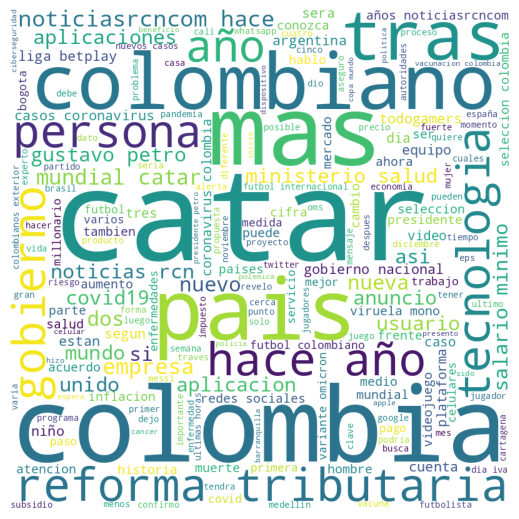

In [243]:
all_text = ' '.join(rcn_news['text_clean'])

wordcloud = WordCloud(
    width = 800, height = 800,
    background_color ='white',
    min_font_size = 10).generate(all_text)

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

deportes


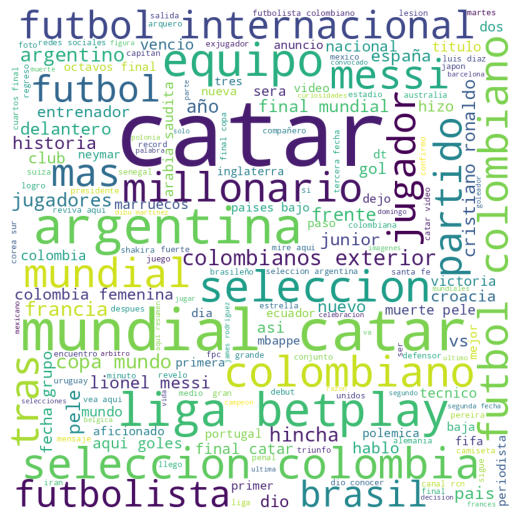

tecnologia


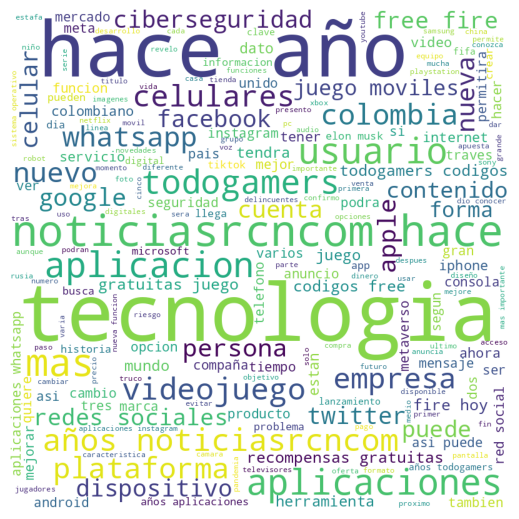

colombia


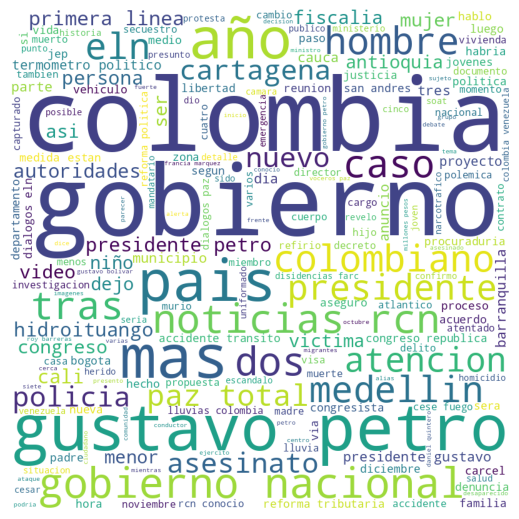

salud


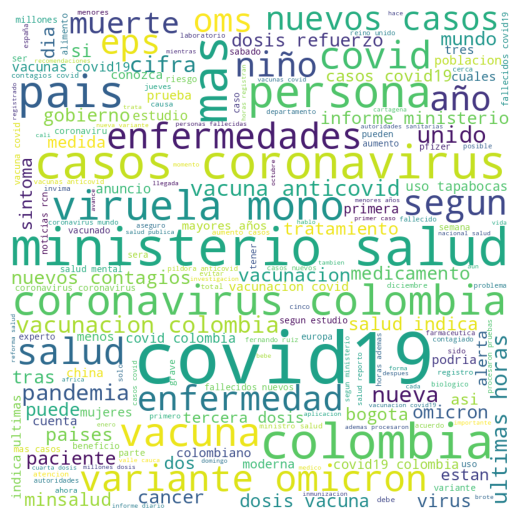

economia


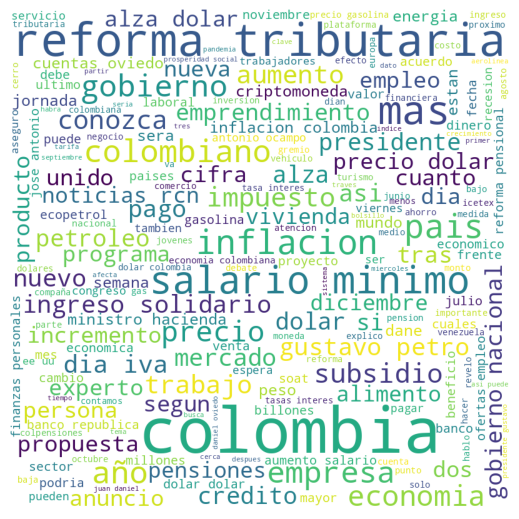

In [244]:
# Wordcloud por label
def plot_wordcloud(label):
    all_text = ' '.join(rcn_news[rcn_news['label'] == label]['text_clean'])
    wordcloud = WordCloud(
        width = 800, height = 800,
        background_color ='white',
        min_font_size = 10).generate(all_text)

    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

for label in rcn_news['label'].unique():
    print(label)
    plot_wordcloud(label)

<Axes: >

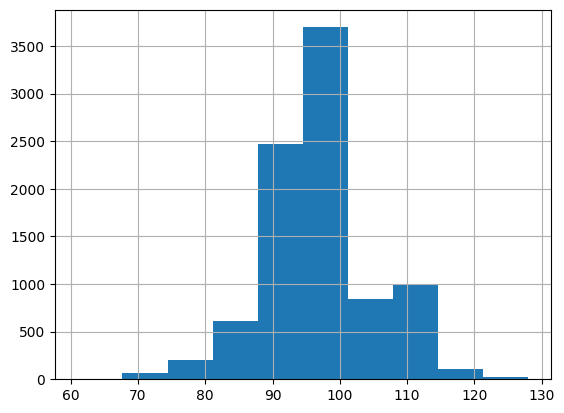

In [245]:
rcn_news['url'].apply(len).hist()

In [247]:
rcn_news['text_length'].describe()

count    9022.000000
mean      155.797495
std        24.569426
min        53.000000
25%       139.000000
50%       156.000000
75%       173.000000
max       266.000000
Name: text_length, dtype: float64

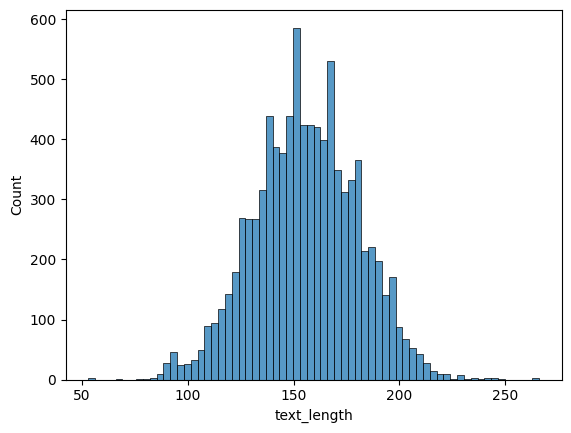

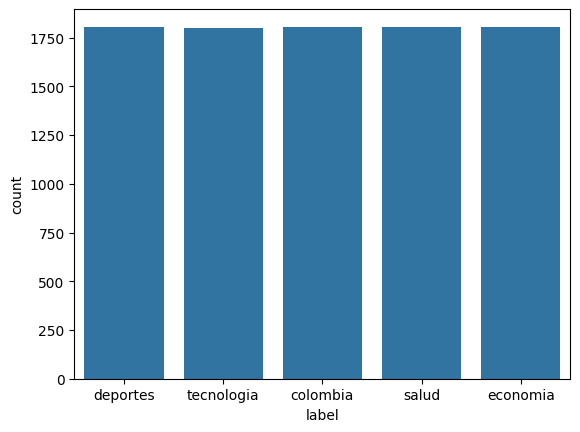

In [248]:
# Histograma de la longitud del texto
sns.histplot(rcn_news['text_length'])
plt.show()

# Gráfico de barras por categorías
sns.countplot(x='label', data=rcn_news)
plt.show()

In [251]:
# Contar la frecuencia de las palabras más comunes
word_freq = Counter(" ".join(rcn_news['text_clean']).split()).most_common(15)
print("Palabras más comunes:")

for word, freq in word_freq:
    print(word, ':', freq)

Palabras más comunes:
colombia : 1946
2022 : 1920
catar : 1717
mas : 1485
salud : 968
años : 930
mundial : 803
gobierno : 741
pais : 683
casos : 641
covid19 : 621
coronavirus : 569
reforma : 562
hace : 540
personas : 528


In [252]:
# Longitud del título
rcn_news['title_length'] = rcn_news['title_clean'].apply(len)

# Análisis de la estructura de las URLs
rcn_news['url_domain'] = rcn_news['url'].apply(lambda x: x.split('/')[2])
print(rcn_news['url_domain'].value_counts())

url_domain
www.noticiasrcn.com    9022
Name: count, dtype: int64


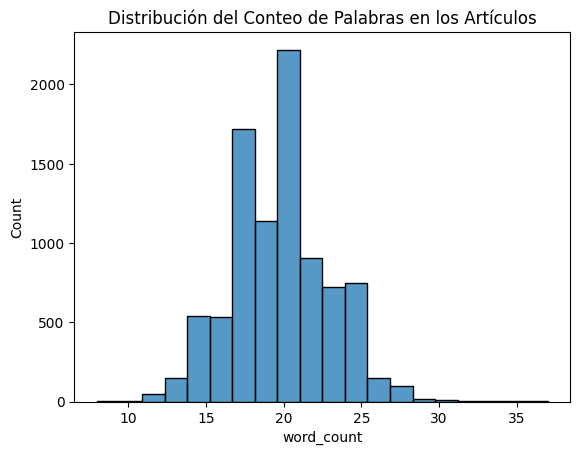

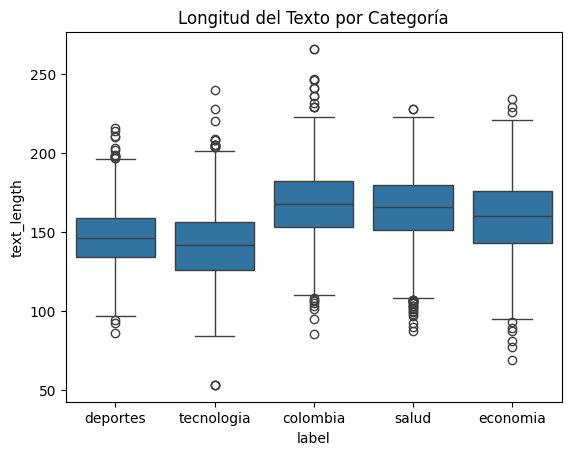

In [253]:
# Distribución del conteo de palabras
sns.histplot(rcn_news['word_count'], bins=20)
plt.title('Distribución del Conteo de Palabras en los Artículos')
plt.show()

# Relación entre la longitud del texto y la categoría
sns.boxplot(x='label', y='text_length', data=rcn_news)
plt.title('Longitud del Texto por Categoría')
plt.show()

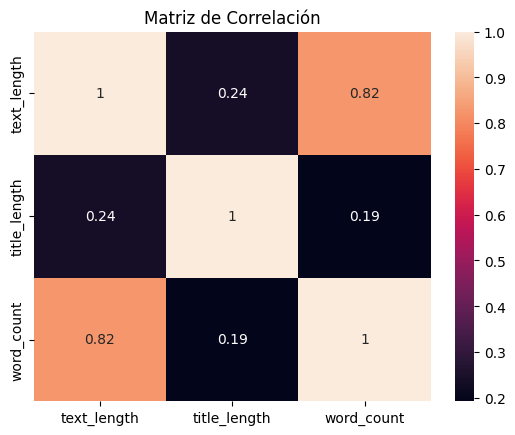

In [254]:
# Correlación entre longitud del texto, longitud del título y conteo de palabras
correlation_matrix = rcn_news[['text_length', 'title_length', 'word_count']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Matriz de Correlación')
plt.show()

In [255]:
# Análisis de las categorías
category_analysis = rcn_news['label'].value_counts()
print("Análisis de Categorías:", category_analysis)

# Análisis de las fuentes
source_analysis = rcn_news['source'].value_counts()
print("Análisis de Fuentes:", source_analysis)

Análisis de Categorías: label
colombia      1806
salud         1806
economia      1806
deportes      1805
tecnologia    1799
Name: count, dtype: int64
Análisis de Fuentes: source
rcn    9022
Name: count, dtype: int64


#### Revisión de sentimiento general sobre una muestra

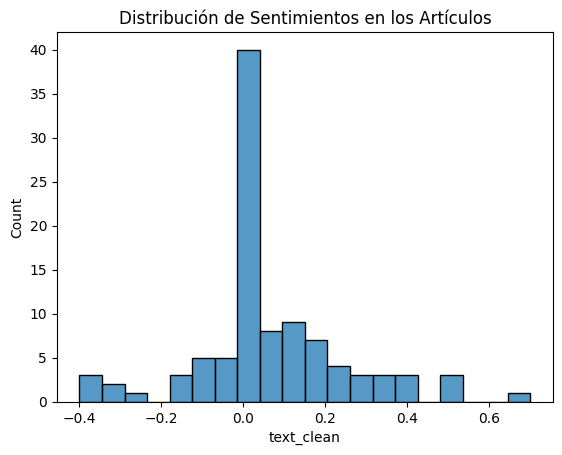

In [283]:
def translate_texto(texto):
    return texto.translate(from_lang='es', to="en")

# Función para calcular la polaridad del sentimiento
def calcular_sentimiento(texto):
    texto = TextBlob(texto)
    texto = translate_texto(texto)
    return texto.sentiment.polarity

sentimientos = rcn_news['text_clean'].sample(100).apply(calcular_sentimiento)

# Visualización de la distribución de sentimientos
sns.histplot(sentimientos, bins=20)
plt.title('Distribución de Sentimientos en los Artículos')
plt.show()

### Feature extraction

In [287]:
X = rcn_news['text_steaming']
y = rcn_news['label']

In [290]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [305]:
X_train_title = rcn_news['title_clean'].iloc[X_train.index]
X_test_title = rcn_news['title_clean'].iloc[X_test.index]

In [291]:
X_train.shape, X_test.shape

((6044,), (2978,))

In [293]:
# Instancia de Vectorizador de textos
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, stop_words=spanish_stopwords)

_tfidf_vectorizer = tfidf_vectorizer.fit(X_train)

#### Separacion de train y test para no sesgar el generador de vectores

In [294]:
_X_train = _tfidf_vectorizer.transform(X_train)
# _X_test = _tfidf_vectorizer.transform(X_test)

In [295]:
pd.DataFrame(
    _X_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).head(3)


,00,01,02,10,100,1000,10000,100000,1000000,101,...,yod,york,youtub,zabarain,zapat,zeld,zidan,zipaquir,zon,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Matrix de similitud coseno

In [353]:
# Función para obtener recomendaciones
def get_recommendations(news_title, num_recommendations=10):
    _id = X_test_title[X_test_title == news_title].index[0]
    news_text =X_test.loc[_id]

    # Obtener el índice del artículo que coincide con el título
    vectorize_news = tfidf_vectorizer.transform([news_text])
    cos_sim_matrix = cosine_similarity(vectorize_news, _X_train)

    # Obtener las puntuaciones de similitud de ese artículo con todos los del entrenamiento
    sim_scores = list(enumerate(cos_sim_matrix[0]))

    # Ordenar los artículos en función de las puntuaciones de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtener las puntuaciones de los 10 artículos más similares
    sim_scores = sim_scores[1:num_recommendations]

    # Obtener los índices de los artículos
    article_indices = [i[0] for i in sim_scores]

    # Devolver los títulos de los 10 artículos más similares
    return article_indices


In [354]:
_n = 105
_titulo = X_test_title.iloc[_n]

print(_titulo)
recommended_indices = get_recommendations(_titulo, 10)

ninos deben vacunados covid 19 entrar eeuu


In [355]:
rcn_news.loc[recommended_indices, ['title', 'label', 'text']]

,title,label,text
4116,Paciente se curo tras 15 anos sin tratamiento por vih,salud,"Enfermedades ¡Insólito! Paciente con VIH se curó luego de 15 años sin recibir ningún tratamiento Este caso, único en el mundo, abre la puerta a numerosas investigaciones sobre nuevos tratamientos ..."
5545,Cual sera el incremento del valor de la upc para el 2022,salud,"Ministerio de Salud Conozca cuál será el incremento del valor de la UPC para el 2022 Esta Unidad de Pago por Capacitación (UPC), es una prima que se reconoce por la atención de cada paciente dentr..."
132,Vacunacion en colombia para jovenes de 15 a 19 anos,salud,"Vacunación en Colombia Arranca la vacunación covid para jóvenes de 15 a 19 años desde este sábado El sábado 21 de agosto inicia la inmunización para este grupo poblacional, así lo anunció el Minis..."
2690,Pablo mari apunalado en un centro comercial de italia,deportes,"Italia Exjugador del Arsenal fue apuñalado en un centro comercial en Milán Un sujeto apuñaló a varias personas en un centro comercial en Milán, Italia. El futbolista Pablo Marí está entre las víct..."
5326,Videojuegos en la nube generaran 13 mil millones de dolares en 2026,tecnologia,"TodoGamers Los videojuegos en la nube generarán 13 mil millones de dólares en 2026 Según un reporte de DFC Intelligence, este tipo de servicio será en referente en el mercado a futuro."
1093,Goles catar 0 2 catar fecha 1 mundial de catar 2022,deportes,Catar 2022 Catar 0-2 Ecuador: reviva aquí los goles del Mundial 2022 Reviva aquí los goles de la victoria de la Selección de Ecuador contra su similar de Catar en el inicio del Mundial.
3376,Rockstar confirma remasterizacion de gta iii san andreas y vice city,tecnologia,"TodoGamers Rockstar hace oficial la remasterización de GTA III, San Andreas y Vice City Después de muchos rumores, finalmente se confirma el regreso de los tres juegos clásicos."
6010,Saab responde a preseleccion de flota de aviones rafale,colombia,"Gobierno Nacional Empresa sueca que ofertó al Gobierno dice que aviones Rafale son ""los más costosos del mercado"" La Presidencia anunció que, en la preselección para el reemplazo de la flota aérea..."
2430,Oms evaluara la viruela del mono para la salud publica,salud,Viruela del mono ¿Podría la viruela del mono convertirse en una emergencia mundial? La OMS convocó a un comité de urgencia para evaluar si la viruela del mono es una emergencia de salud pública.


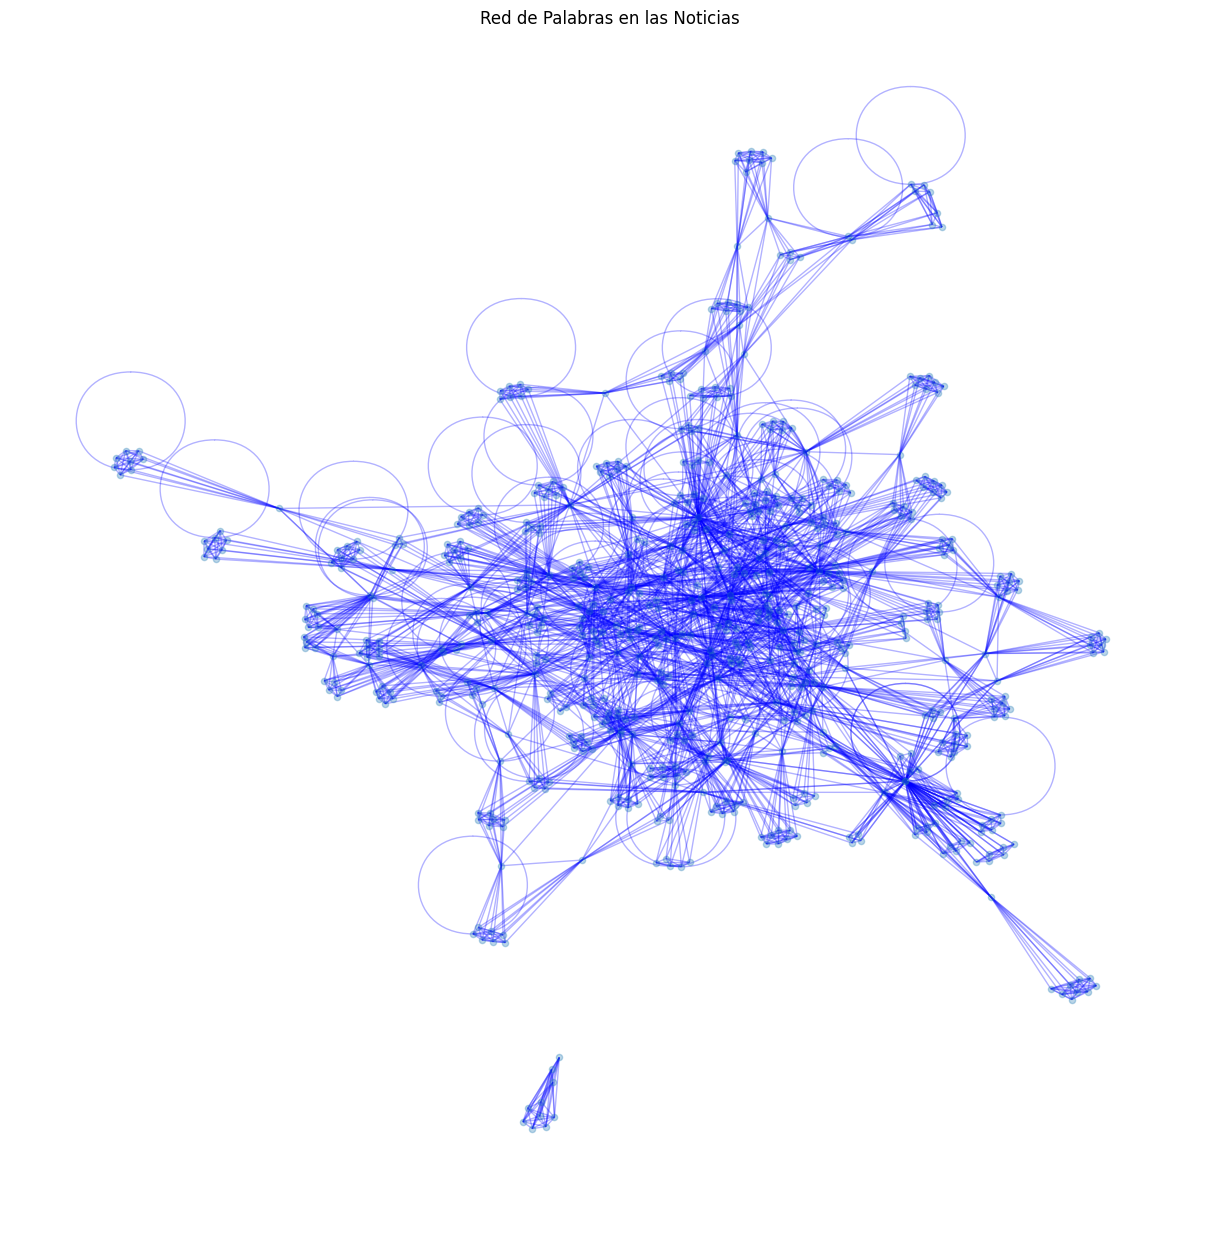

In [344]:
# Red de palabras
G = nx.Graph()
for text in rcn_news['text_steaming'][:100]:
    palabras = text.split()[:10]
    G.add_edges_from(combinations(palabras, 2))

# Dibujar la red
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=False, node_size=20, edge_color='blue', alpha=0.3)
plt.title('Red de Palabras en las Noticias')
plt.show()
